In [1]:
from statistics import mean
from typing import List, Tuple, Any
import numpy as np
import pandas as pd
from scapy.layers.dot11 import Dot11, RadioTap
from scapy.utils import PcapReader

PacketSet = List[Tuple[Any, Any, Dot11]]

In [2]:
def read_from_pcap(path: str, bpf_filter: str= "") -> PacketSet:
    """
    This function reads the .pcap file and applies the BPF filter given in input.

    :param path: Path of the .pcap file to extract.
    :param bpf_filter: BPF filter to apply to the .pcap file.
    :return: List of filtered packets.
    """
    packet_stream = []
    with PcapReader(filename=path) as pcap_reader:
        for pkt in pcap_reader:
            dot11_packet = len(pkt), pkt.time, pkt
            packet_stream.append(dot11_packet)
    return packet_stream


def dot11_to_feature(pkt: Dot11) -> np.ndarray:
    """
    This function returns a numpy ndarray that contains an encoding of the most important features of the 802.11 frame.
    The features are the following:
     * Source MAC Address (addr2).
     * Destination MAC Address (addr1).
     * Duration field (ID).

    :param Dot11 pkt: the packet to process.
    :return: The ndarray that encodes the extracted features of the input packet.
    """
    return np.array([pkt.addr2, pkt.addr1, pkt.ID])


def feature_expansion_raw(pkt_list: PacketSet) -> pd.DataFrame:
    """
    This function extract the main features from each packet's Wi-Fi header and collects everything into a Pandas
    DataFrame.
    :param pkt_list: List of the filtered packets from the .pcap file.
    :return: Pandas Dataframe of each packet and their main features.
    """
    pkt_length = list(map(lambda pkt, *_,: pkt[0], pkt_list))
    x = list(map(lambda *pkt: dot11_to_feature(pkt[0][2]), pkt_list))
    timestamps = list(map(lambda *t: t[0][1], pkt_list))
    pd_x = pd.DataFrame(x, columns=["SourceAddress", "DestinationAddress", "Duration"])
    pd_x.loc[:, "Duration"] = pd_x.loc[:, "Duration"].astype(int)
    pd_x.loc[:, "PacketLength"] = pd.Series(pkt_length, dtype=int)
    pd_x.loc[:, "Timestamp"] = pd.Series(timestamps, dtype=float)
    pd_x.loc[:, "TimestampOffset"] = pd_x["Timestamp"] - pd_x["Timestamp"].min()
    return pd_x

In [33]:
path = "captures/network/"
captures_files_normal = [path+"capture_test-08.cap"]
captures = [read_from_pcap(path=f) for f in captures_files_normal]
captures_pd = list(map(lambda x: feature_expansion_raw(x), captures))
captures_pd = pd.concat(captures_pd, axis=0)
#captures_pd.dropna(axis=0, how='any', inplace=True)
captures_pd.loc[:, "Anomaly"] = 0
captures_pd.loc[(captures_pd['SourceAddress'] == '0a:1a:cc:8e:ca:9e'), 'Anomaly'] = 1

In [38]:
import seaborn as sns

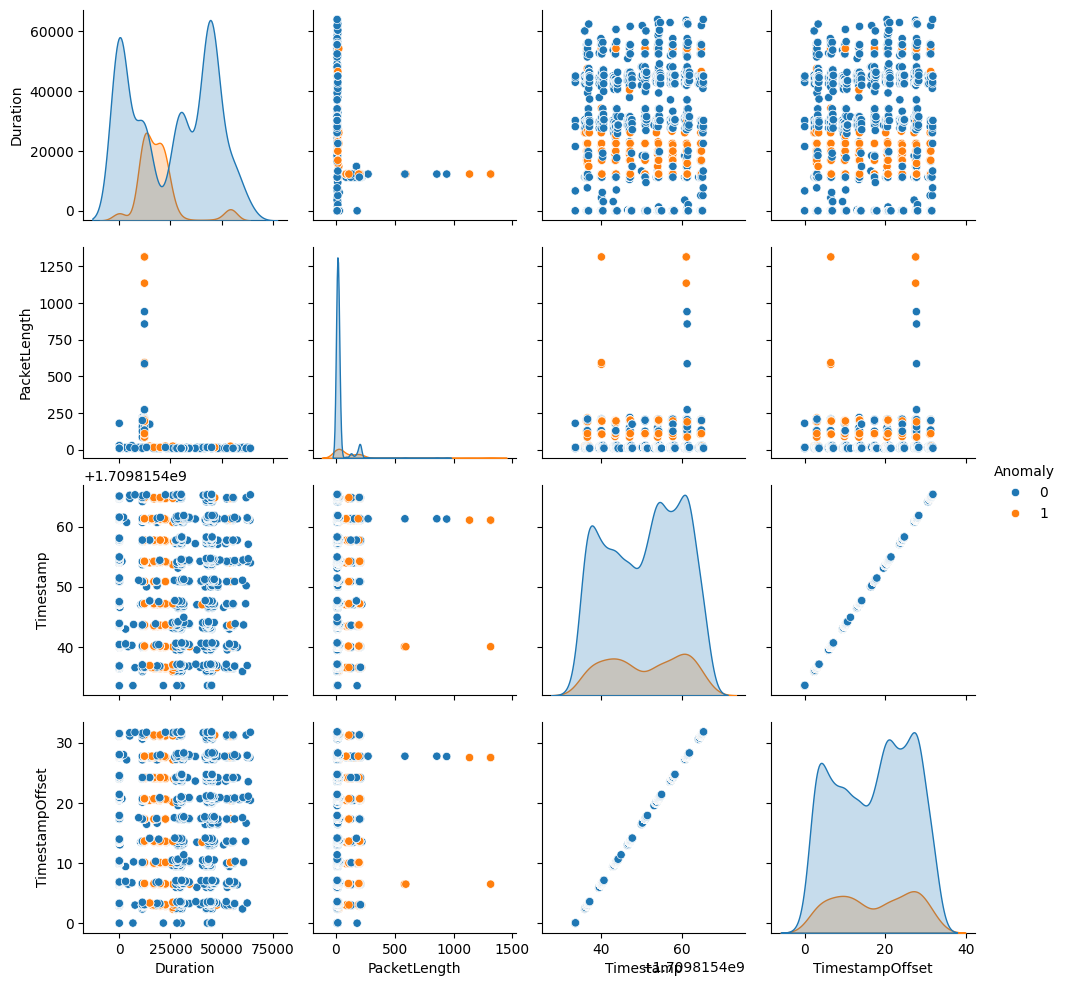

In [39]:
sns.pairplot(captures_pd, hue="Anomaly")

In [42]:
import seaborn.objects as so

/tmp/ipykernel_4961/2970251982.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=-45)


[Text(0, 0, '00:c0:ca:a9:cd:ce'),
 Text(1, 0, '0a:1a:cc:8e:ca:9e'),
 Text(2, 0, '00:c0:ca:a9:e7:52'),
 Text(3, 0, '7c:c2:25:9c:f3:e4'),
 Text(4, 0, '00:00:00:00:00:00')]

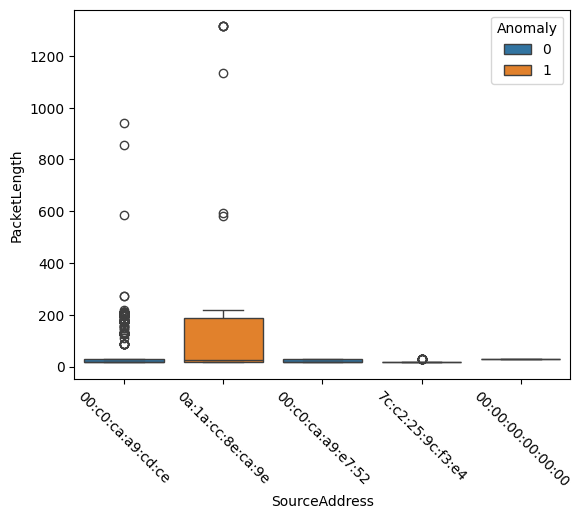

In [45]:
g = sns.boxplot(data=captures_pd, x="SourceAddress", y="PacketLength", hue="Anomaly")
g.set_xticklabels(g.get_xticklabels(), rotation=-45)